# National emissions reported to the Convention on Long-range Transboundary Air Pollution (LRTAP Convention)
---

This dataset contains the emissions data used in the European Union's annual submission to the UNECE LRTAP Convention. It is the recommended dataset for users wishing to explore trends in emissions of air pollutants or to compare data from different countries and/or sources.  The dataset is used by EEA for our indicators and in assessment reports.

The dataset is based on the official country reports provided to the LRTAP Convention and to EEA.  Where gaps exist in the LRTAP data due to non-reporting, in the first instance other officially-reported emissions data are used to fill these. A simple interpolation/extrapolation process is finally used to fill remaining gaps to provide a consistent set of data suitable for assessment purposes.

Data are available for EEA member countries from 1990 onwards for the main air pollutants CO, NH3, NMVOC, NOX, PM10, PM2.5, and SO2, and for certain heavy metals and POPs.

This is also the recommended dataset for users wishing to assess the progress being made by Parties to their commitments under the LRTAP Convention and its protocols e.g. comparison of reported national totals to the 2010 national ceilings (limits) specified in the LRTAP Convention's Gothenburg Protocol.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Data/CLRTAP_NVFR14_V21_GF.csv', on_bad_lines='skip', sep='\t')
df.head()

,Country_Code,Country,Pollutant_name,Format_name,Sector_code,Year,Emissions,Unit,Notation,VersionId,Parent_sector_code,Sector_name
0,AT,Austria,As,NFR 2014-1,1B2aiv,1990,NaN,Mg,NR,2,NATIONAL TOTAL,Fugitive emissions oil: Refining / storage
1,AT,Austria,As,NFR 2014-1,1B2av,1990,NaN,Mg,NR,2,NATIONAL TOTAL,Distribution of oil products
2,AT,Austria,As,NFR 2014-1,1B2b,1990,NaN,Mg,NR,2,NATIONAL TOTAL,Fugitive emissions from natural gas (explorati...
3,AT,Austria,As,NFR 2014-1,1B2c,1990,NaN,Mg,NR,2,NATIONAL TOTAL,"Venting and flaring (oil, gas, combined oil an..."
4,AT,Austria,As,NFR 2014-1,1B2d,1990,NaN,Mg,NR,2,NATIONAL TOTAL,Other fugitive emissions from energy production


## EDA
Null values

In [3]:
def getNullValues(df):
    total = df.isnull().sum().sort_values(ascending = False)
    total = total[df.isnull().sum().sort_values(ascending = False) != 0]
    percent = total / len(df) * 100
    percent = percent[df.isnull().sum().sort_values(ascending = False) != 0]
    concat = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    print(concat)
    df.info()
getNullValues(df)

                      Total    Percent
Emissions           2741312  72.240546
Notation            2444683  64.423617
Parent_sector_code   327600   8.633094
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3794700 entries, 0 to 3794699
Data columns (total 12 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Country_Code        object 
 1   Country             object 
 2   Pollutant_name      object 
 3   Format_name         object 
 4   Sector_code         object 
 5   Year                int64  
 6   Emissions           float64
 7   Unit                object 
 8   Notation            object 
 9   VersionId           int64  
 10  Parent_sector_code  object 
 11  Sector_name         object 
dtypes: float64(1), int64(2), object(9)
memory usage: 347.4+ MB


In [27]:
df['Sector_name'].value_counts()

Fugitive emissions oil: Refining / storage    27300
Manure management - Horses                    27300
Manure management - Dairy cattle              27300
Manure management - Non-dairy cattle          27300
Manure management - Sheep                     27300
                                              ...  
Pulp and paper industry                       27300
Other product use                             27300
Other solvent use                             27300
Printing                                      27300
Other waste                                   27300
Name: Sector_name, Length: 139, dtype: int64

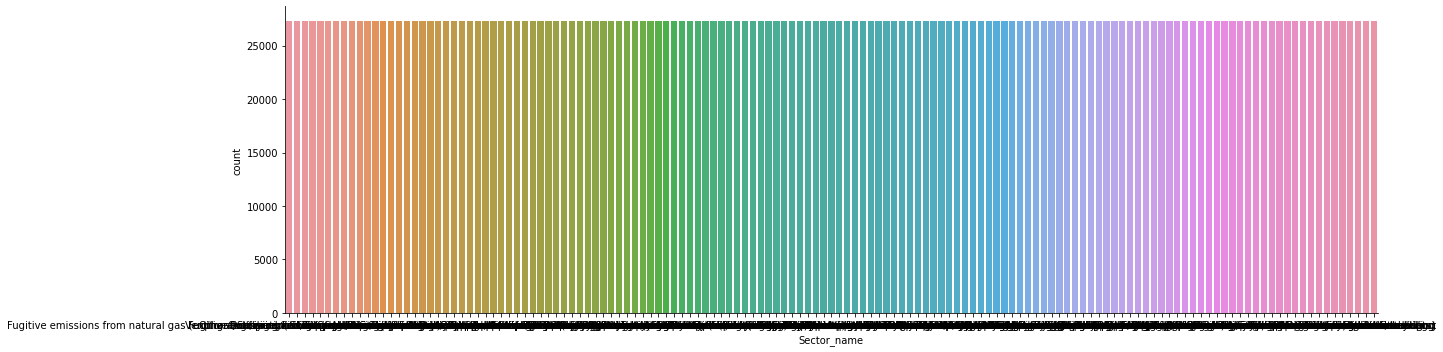

In [28]:
sns.catplot(x = "Sector_name", kind = "count",  data = df, height=5, aspect = 4)

Analysis by type and pollution means

<AxesSubplot:xlabel='Country'>

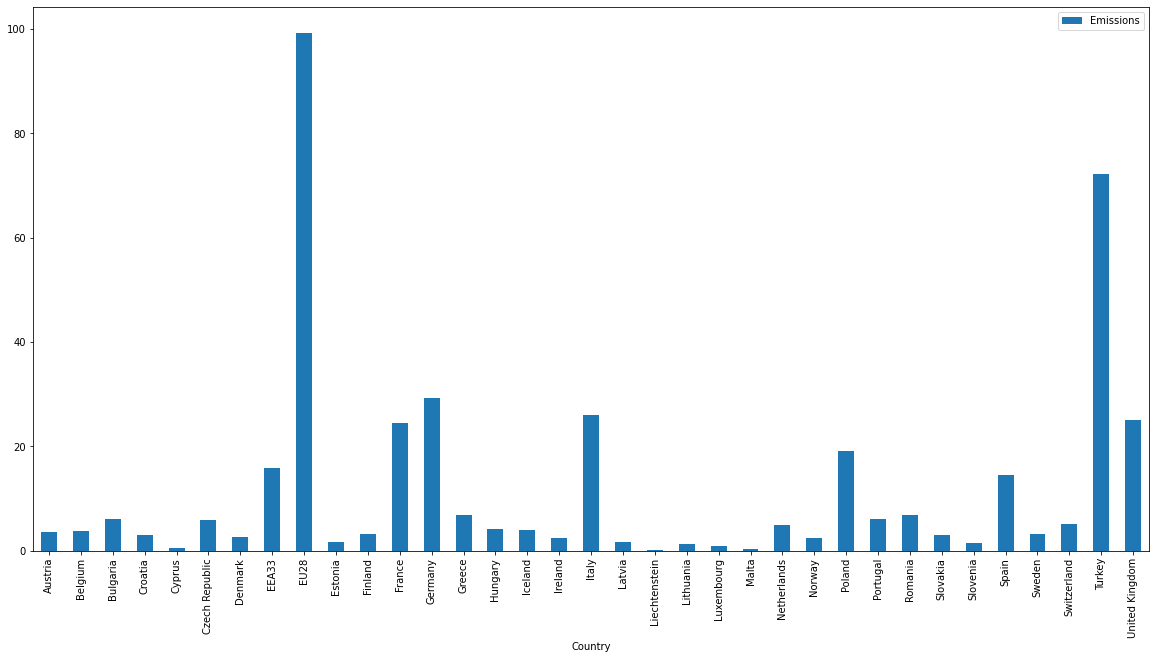

In [31]:
grp = df.groupby(["Country"]).mean()["Emissions"].to_frame()
grp.plot.bar(figsize = (20,10))

AttributeError: 'SeriesGroupBy' object has no attribute 'to_frame'

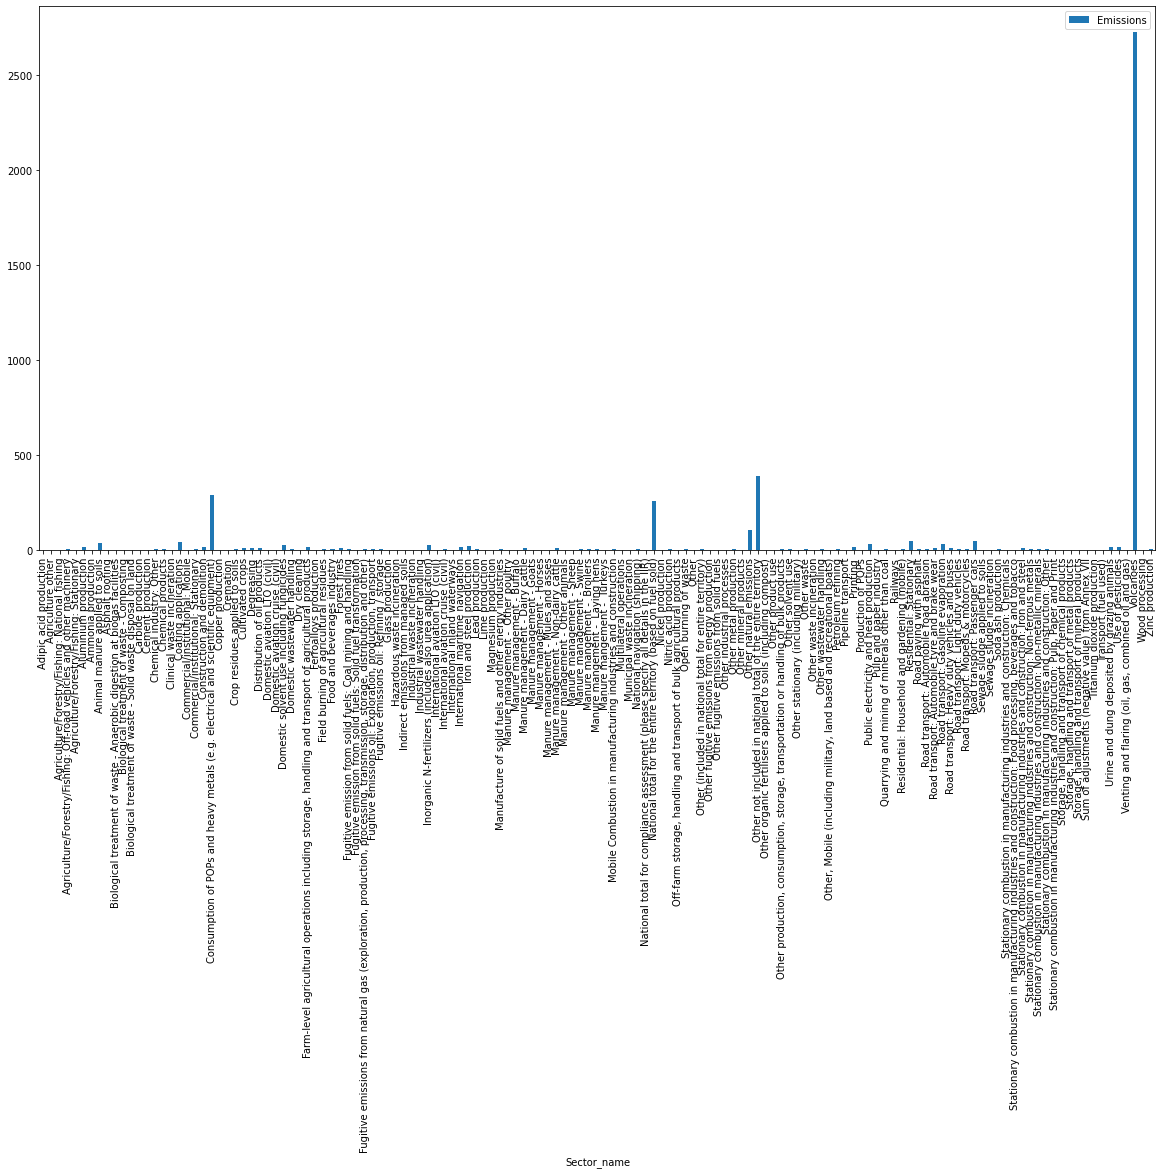

In [8]:
grp = df.groupby(["Sector_name"]).mean()["Emissions"].to_frame()
grp.plot.bar(figsize = (20,10))

grp = df.groupby(["Sector_name"]).mean()["Country"].to_frame()
grp.plot.bar(figsize = (20,10))

<AxesSubplot:xlabel='Year'>

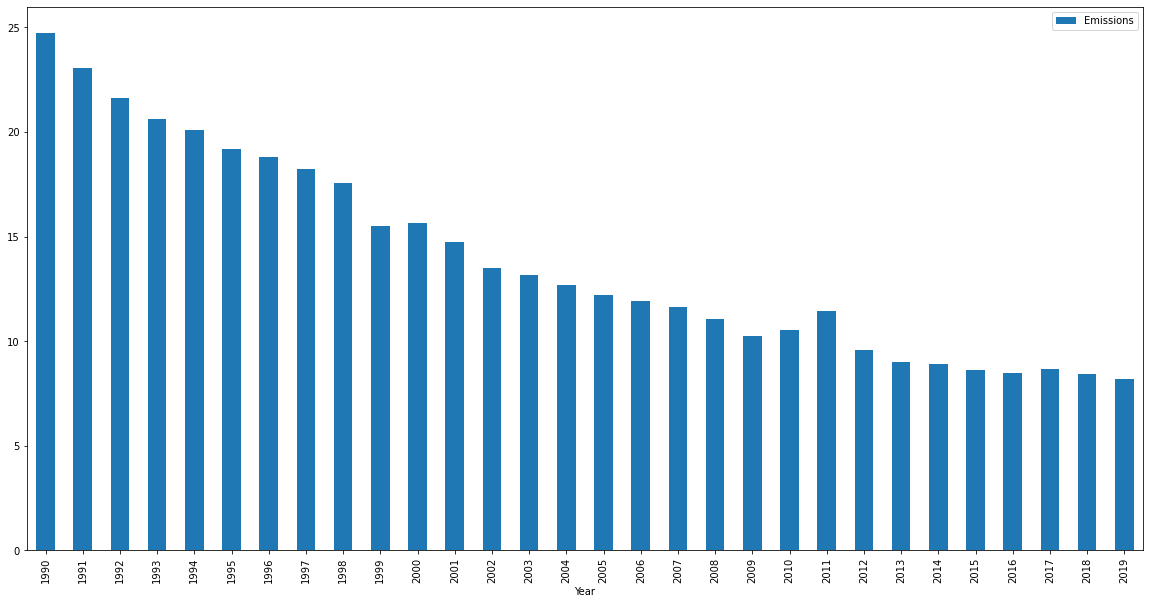

In [34]:
grp = df.groupby(["Year"]).mean()["Emissions"].to_frame()
grp.plot.bar(figsize = (20,10))

<AxesSubplot:xlabel='Year', ylabel='Country'>

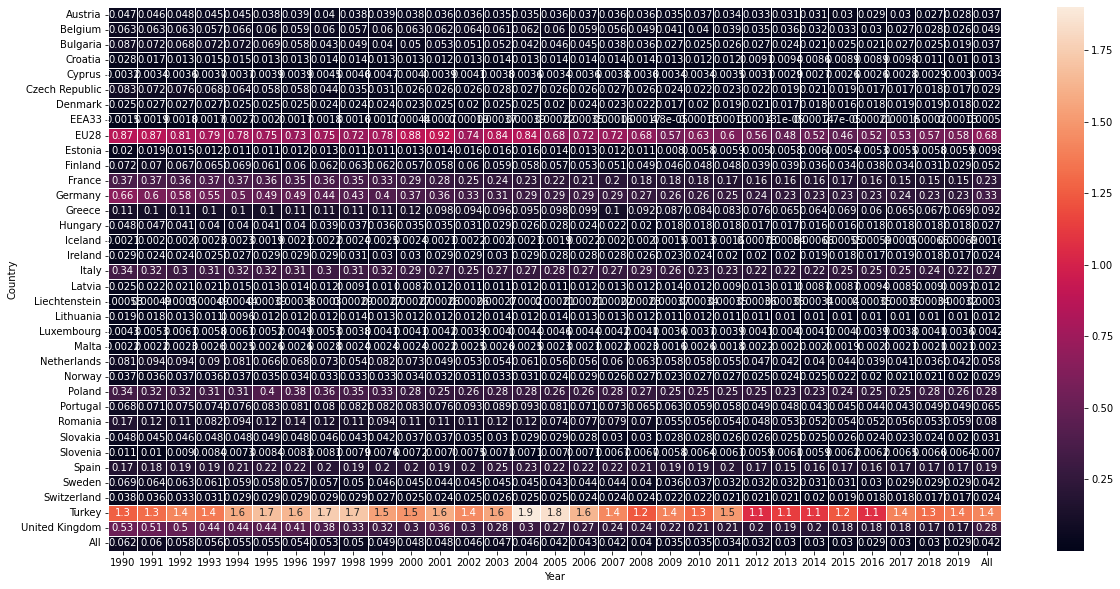

In [39]:
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(df.pivot_table('Emissions', index='Country',columns=['Year'],aggfunc='median',margins=True),ax = ax,annot=True, linewidths=.5)

Trends by countries

<AxesSubplot:xlabel='Year'>

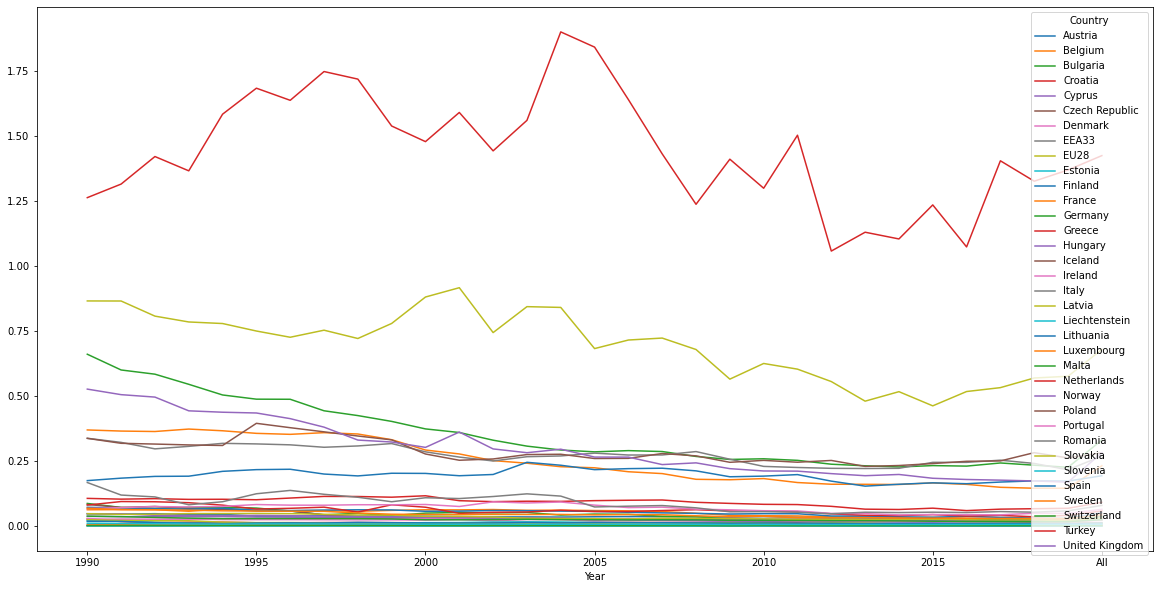

In [44]:
temp = df.pivot_table('Emissions', index='Year',columns=['Country'],aggfunc='median',margins=True).reset_index()
temp = temp.drop("All", axis = 1)
temp = temp.set_index("Year")
temp.plot(figsize=(20,10))

## Geoplotting

In [5]:
europe = gpd.read_file('Data/Europe_coastline_shapefile/Europe_coastline_poly.shp')
europe.info()  # separate per o/u

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 71520 entries, 0 to 71519
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Id        71520 non-null  int64   
 1   geometry  71520 non-null  geometry
dtypes: geometry(1), int64(1)
memory usage: 1.1 MB


<AxesSubplot:>

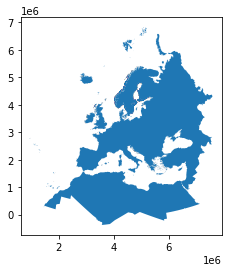

In [6]:
europe.plot()

## Time Series Analysis

In [9]:
df['Year'] = pd.to_datetime(df['Year'])

df_emission = df[["Year", "Emissions"]]
df_emission = df_emission.set_index("Year")
df_emission = df_emission.dropna()

df_emission_resample = df_emission.resample(rule = "M").mean().fill()
df_emission.plot(figsize = (20,10))

AttributeError: 'DataFrame' object has no attribute 'fill'